# Assignment 2
## CT5134: Agents, Multi-Agent Systems and Reinforcement Learning

Student Name: **Jash Prakash Rana**

Student ID: **22222806**

---
The “deterministic” FrozenLake is a toy problem from the so called “grid world” category of problems. In this problem the agent lives in a square grid and can move in 4 directions, “up”, “down”, “left” and “right”. The agent always starts in the top-left position and its goal is to reach the bottom right position on the grid.

Just like the basic Gridworld, actions are deterministic, i.e., a move to the “right” will always move the agent to the cell directly to their right. The FrozenLake however does have holes in the ice and if the agent falls in, it will drown. Any action which causes a move off the grid results in the agent’s state remaining unchanged.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
'''
Main Variables
'''

# Grid height and width
BOARD_ROWS = 5
BOARD_COLS = 5

# State where the agent wins (program stops)
WIN_STATE = (4, 4)

# Holes created to stop program whenever agent falls into it
LOSE_STATE = [(1, 0), (1, 3), (3, 1), (4, 2)] 

#Agent start point on the grid
START = (0, 0)

# to enable/disable verbose output while running program
DEBUG = False  

### State Class
State class provides:
1. Understanding and providing current state of the agent.
2. Defining policy for the agent and generate rewards.
3. Generating actions based on set rules in the grid.
4. Determine to end actions based on conditions defined.

In [3]:
# Ref: Dr. Patrick Mannion - Week 09 "Gridworld_valueIteration_q_learning_Exercise2_fixed.py"

class State:
    def __init__(self, state=START):        
        self.state = state
        self.isEnd = False        

    def get_reward(self):
        if self.state == WIN_STATE:
            return 10        
        elif self.state in LOSE_STATE:
            return -5
        else:
            return -1

    def is_end_func(self):
        if (self.state == WIN_STATE) or (self.state in LOSE_STATE):
            self.isEnd = True

    def nxt_position(self, action):
        if action == 0:                
            nxt_state = (self.state[0] - 1, self.state[1])
        elif action == 1:
            nxt_state = (self.state[0] + 1, self.state[1])
        elif action == 2:
            nxt_state = (self.state[0], self.state[1] - 1)
        else:
            nxt_state = (self.state[0], self.state[1] + 1)
            
        if (nxt_state[0] >= 0) and (nxt_state[0] < BOARD_ROWS):
            if (nxt_state[1] >= 0) and (nxt_state[1] < BOARD_COLS):
                return nxt_state  # if next state legal
        return self.state  # Any move off the grid leaves state unchanged


### Agent Class
Agent class creates an Agent as a class object with certain properties defined in the constructor function (like alpha, gamma, etc.). Some of the major functions defined are:

1. choose_action: According to epsilon, chooses the next action in the grid for the agent [1].
2. take_action: Takes the next action considering best case for the agent [1].
3. best_action: Checks if the previous q values considered can be worse than the current [1].
4. q_max: Returns the maximum q-values found while learning [1].
5. decay_epsilon: Generates a new value for epsilon as per the decay rate [2].
$$ \epsilon = max(0.00, \epsilon * (1.0 - decayrate)) $$
6. q_learning: The main function which is defined to make an agent object learn the game in the given episode value, and find out the best paths and best q-values to navigate through the grid. It is an iterative process used to determine which action gives the maximum rewards at the current state [1]. The Bellman Equation is used to determine the value of a particular state and deduce how good it is to be in/take that state. The optimal state will give us the highest optimal value. The equation is:
$$ Q = Old Q(S, A) + \alpha * [R(S,A) + \gamma * [Max Q'(S, A) - Q(S, A)]$$
7. show_values: Outputs the max q-values found during training the agent and showcases it in a grid format [1].
---
References: 
1. Dr. Patrick Mannion - Week 09 "Gridworld_valueIteration_q_learning_Exercise2_fixed.py"
2. Kavukcuoglu et al (2015), "Human-level control through deep reinforcement learning."

In [4]:
# Ref: Dr. Patrick Mannion - Week 09 "Gridworld_valueIteration_q_learning_Exercise2_fixed.py"

class Agent:

    def __init__(self, alpha = 0.5, gamma = 0.9, epsilon = 0.10):
        self.states = []
        self.actions = [0, 1, 2, 3]  # up, down, left, right
        self.State = State()
        self.discount = gamma
        self.lr = alpha
        self.eps = epsilon
        # initialise state values
        self.action_values = {}        
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                for k in range(len(self.actions)):
                    self.action_values[(i, j, k)] = 0.0  # set initial value to 0, for Q(s,a)
        
        self.new_action_values = []

    def choose_action(self, current_state):
        # choose action according to policy eps-greedy
        if np.random.uniform(0, 1) <= self.eps:
            action = np.random.choice(self.actions)
            if DEBUG:
                print("selecting random action")
        else:
            action = self.best_action(current_state)
        return action

    def take_action(self, action):
        position = self.State.nxt_position(action)
        self.State.state = position

    def best_action(self, state):
        best = -1
        max_val = -100000000
        for a in self.actions:
            q_val = self.action_values[state[0], state[1], a]
            if q_val >= max_val:
                max_val = q_val
                best = a
        return best

    def q_max(self, state):
        best = self.best_action(state)
        return self.action_values[state[0], state[1], best]
    
    # Ref: Mnih et al (2015), 
    # "Human-level control through deep reinforcement learning."
    def decay_epsilon(self, decay_rate):
        return max(0.00, self.eps * (1.0 - decay_rate))

    # Q-learning implementation
    def q_learning(self, episodes, epsilon = False, decay_rate = 0.0):
        
         # episode counter
        x = 0 

        # list to calculate rewards per episode
        self.reward_list = [] 

        # list to calculate epsilon decay
        self.eps_list = [self.eps] 
        
        while x < episodes:
            # Init S
            self.State.isEnd = False
            self.State.state = START  # Re init S Start state
            step = 0
                       
            if DEBUG:
                print("**** Beginning episode", x, "****")
                self.show_values()
            
            reward_sum = 0

            while True:  # repeat for each step of the episode (until S is terminal)

                # Store current state for Q update
                current_state = (self.State.state[0], self.State.state[1])

                # Choose action A from S using policy derived from Q (e-greedy)
                action = self.choose_action(current_state)

                # Take action A observe R and next State S'
                self.take_action(action)
                reward = self.State.get_reward()
                self.State.is_end_func()
                next_state = self.State.state[0], self.State.state[1]

                # Update state action values
                old_q = self.action_values[current_state[0], current_state[1], action]
                max_q = self.q_max(next_state)
                new_q = old_q + self.lr * (reward + self.discount * max_q - old_q)
                self.action_values[current_state[0], current_state[1], action] = new_q
                
                step += 1
                if DEBUG:
                    print("step", step, "state", current_state, "action", action, "reward", reward,
                          "next_state", next_state, "old_q", old_q, "max_q", max_q, "new_q", new_q)
                
                reward_sum += reward
                # Check if s is terminal
                if self.State.isEnd:
                    self.reward_list.append(reward_sum) #Appending reward in each step of the episode
                    break

                # S <- S' automatically when I took the action   
            
            x += 1
            
            if epsilon == True:
                self.eps = self.decay_epsilon(decay_rate)
                self.eps_list.append(self.eps)
            
    def show_values(self):
        for i in range(0, BOARD_ROWS):
            print('----------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                mx_nxt_value = -1000
                for a in self.actions:
                    nxt_value = self.action_values[(i, j, a)]
                    if nxt_value >= mx_nxt_value:
                        mx_nxt_value = nxt_value                
                out += str(round(mx_nxt_value, 3)).ljust(6) + ' | '
            print(out)
        print('----------------------------------')


#### Moving Average Function
Finds the moving average over a list of integers for a given window size.
Useful to show rewards every episode when plotted for less cluttered plots.


In [5]:
#Ref: https://stackoverflow.com/questions/11352047/finding-moving-average-from-data-points-in-python

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

# Results 1
## Default Hyperparameters to train the Agent
alpha = 0.5, gamma = 0.9, epsilon = 0.10

In [6]:
ag = Agent()
ag.q_learning(episodes = 10000)
ag.show_values()


----------------------------------
| -0.434 | 0.629  | 1.81   | 3.122  | 4.58   | 
----------------------------------
| 0.0    | 1.81   | 3.122  | 0.0    | 6.2    | 
----------------------------------
| 1.81   | 3.122  | 4.58   | 6.2    | 8.0    | 
----------------------------------
| -1.945 | 0.0    | 6.2    | 8.0    | 10.0   | 
----------------------------------
| -1.855 | -1.426 | 0.0    | 10.0   | 0.0    | 
----------------------------------


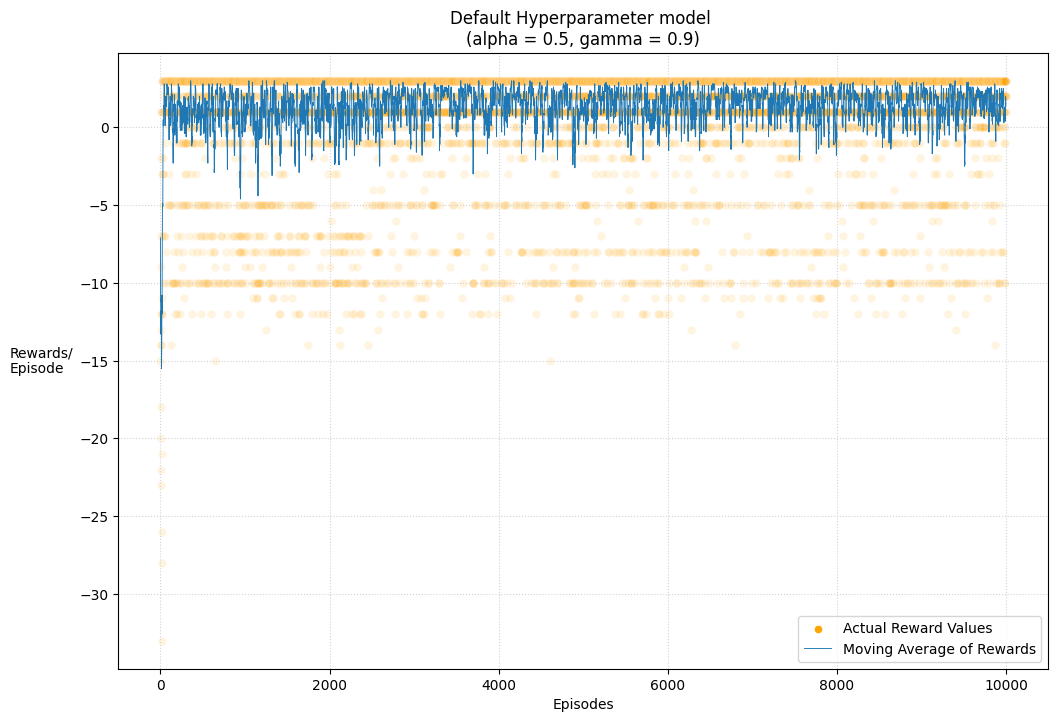

In [7]:
fig = plt.figure(figsize = (12, 8))

reward_list = movingaverage(ag.reward_list, 10)

sns.scatterplot(ag.reward_list, alpha = 0.12, color = "orange")
sns.lineplot(reward_list, linewidth = 0.65)
plt.xlabel("Episodes")
plt.ylabel("Rewards/\nEpisode", rotation = "horizontal", 
           ha='right', va='center', ma='left')
plt.title("Default Hyperparameter model \n(alpha = 0.5, gamma = 0.9)")
plt.grid(linestyle = ':', color = "lightgrey")

#Ref: https://stackoverflow.com/questions/12848808/set-legend-symbol-opacity-with-matplotlib
leg = plt.legend(['Actual Reward Values','Moving Average of Rewards'], loc = "lower right")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig = plt.plot()

# Results 2
## Default Hyperparameters with $\epsilon$ decay to train the Agent
alpha = 0.5, gamma = 0.9, epsilon = 0.10, decay_rate = 0.0005

In [8]:
ag1 = Agent()
ag1.q_learning(episodes = 10000, epsilon = True, decay_rate = 0.0005)
ag1.show_values()

----------------------------------
| -0.434 | 0.629  | 1.81   | 1.815  | 4.457  | 
----------------------------------
| 0.0    | 1.81   | 3.122  | 0.0    | 6.2    | 
----------------------------------
| -2.066 | 3.122  | 4.58   | 6.2    | 8.0    | 
----------------------------------
| -1.732 | 0.0    | 6.2    | 8.0    | 10.0   | 
----------------------------------
| -1.426 | -0.975 | 0.0    | 5.0    | 0.0    | 
----------------------------------


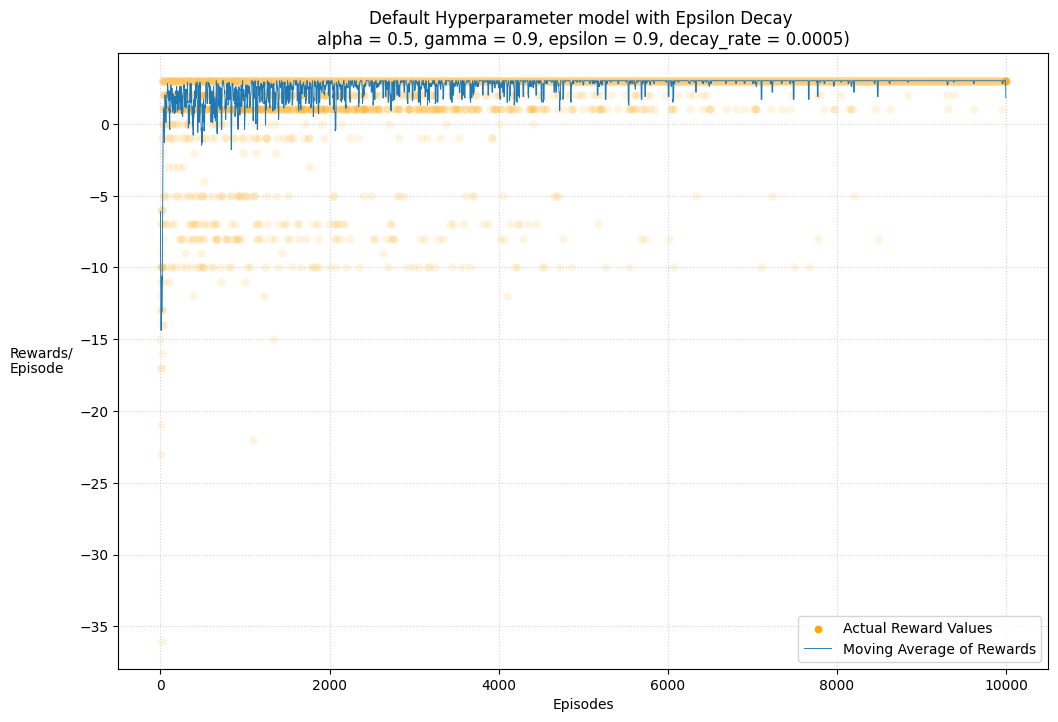

In [9]:
fig = plt.figure(figsize = (12, 8))

reward_list = movingaverage(ag1.reward_list, 10)

sns.scatterplot(ag1.reward_list, alpha = 0.12, color = "orange")
sns.lineplot(reward_list, linewidth = 0.65)
plt.xlabel("Episodes")
plt.ylabel("Rewards/\nEpisode", rotation = "horizontal", 
           ha='right', va='center', ma='left')
plt.title("Default Hyperparameter model with Epsilon Decay \nalpha = 0.5, gamma = 0.9, epsilon = 0.9, decay_rate = 0.0005)")
plt.grid(linestyle = ':', color = "lightgrey")

#Ref: https://stackoverflow.com/questions/12848808/set-legend-symbol-opacity-with-matplotlib
leg = plt.legend(['Actual Reward Values','Moving Average of Rewards'], loc = "lower right")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig = plt.plot()

<AxesSubplot: >

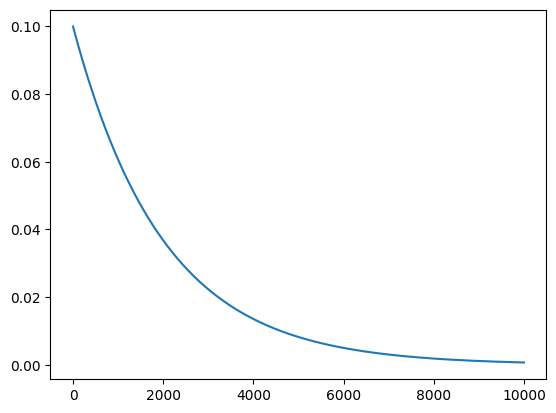

In [10]:
sns.lineplot(ag1.eps_list)

# Results 3
## Random Hyperparameters with $\epsilon$ decay to train the Agent
alpha = 0.01, gamma = 0.5, epsilon = 0.5, decay_rate = 0.0005

In [11]:
ag2 = Agent(alpha = 0.01, gamma = 0.5, epsilon = 0.05)
ag2.q_learning(episodes = 10000, epsilon = True, decay_rate = 0.0005)
ag2.show_values()

----------------------------------
| -1.906 | -1.813 | -1.637 | -1.406 | -0.837 | 
----------------------------------
| 0.0    | -1.625 | -1.25  | 0.0    | 0.693  | 
----------------------------------
| -1.203 | -1.288 | -0.5   | 1.0    | 4.0    | 
----------------------------------
| -1.076 | 0.0    | -0.067 | 3.118  | 10.0   | 
----------------------------------
| -0.983 | -0.869 | 0.0    | 0.585  | 0.0    | 
----------------------------------


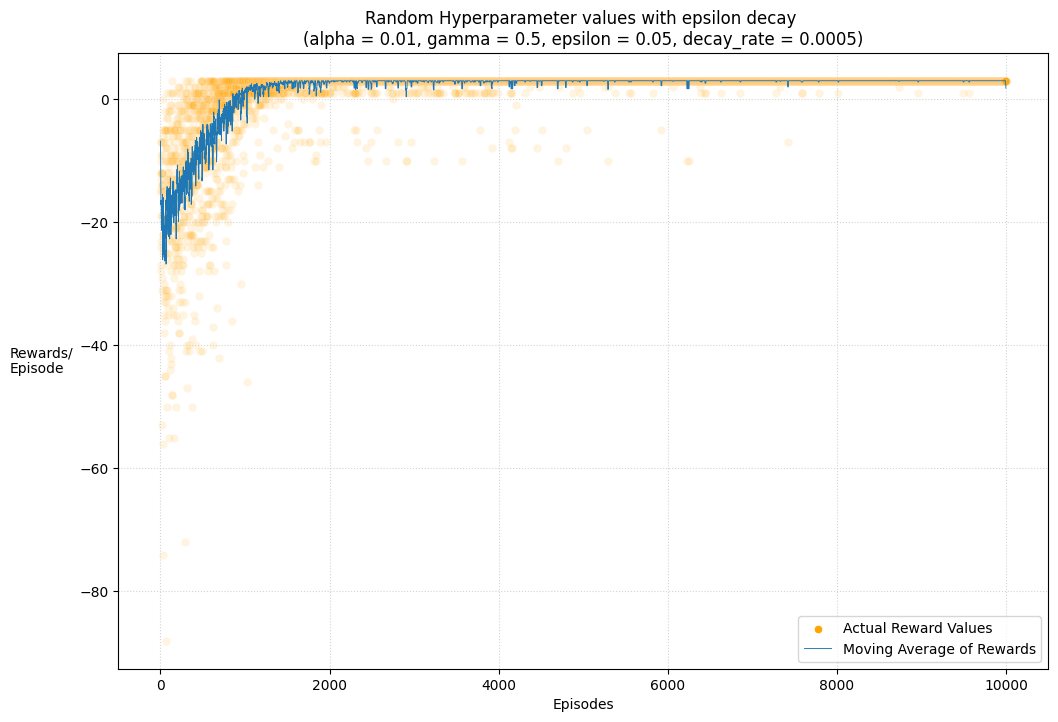

In [12]:
fig = plt.figure(figsize = (12, 8))

reward_list = movingaverage(ag2.reward_list, 10)

sns.scatterplot(ag2.reward_list, alpha = 0.12, color = "orange")
sns.lineplot(reward_list, linewidth = 0.65)
plt.xlabel("Episodes")
plt.ylabel("Rewards/\nEpisode", rotation = "horizontal", 
           ha='right', va='center', ma='left')
plt.title("Random Hyperparameter values with epsilon decay \n(alpha = 0.01, gamma = 0.5, epsilon = 0.05, decay_rate = 0.0005)")
plt.grid(linestyle = ':', color = "lightgrey")

#Ref: https://stackoverflow.com/questions/12848808/set-legend-symbol-opacity-with-matplotlib
leg = plt.legend(['Actual Reward Values','Moving Average of Rewards'], loc = "lower right")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig = plt.plot()

<AxesSubplot: >

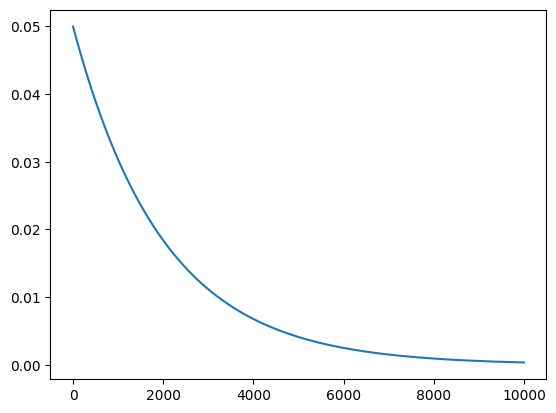

In [13]:
sns.lineplot(ag2.eps_list)